In [1]:
# xarray to read NETCDF
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import annotate

In [2]:
CanESM5 = xr.open_mfdataset('data/NMME/CanESM5/*.nc')
CanESM5['X'] = CanESM5['X'] - 180
chirps = xr.open_dataset('data/CHIRPS/chirps-v2.0.monthly.nc')

In [3]:
CanESM5_south_sudan = (CanESM5.sel(Y=slice(3.5, 12.5), X=slice(25, 35))
                       .rename({'Y': 'latitude', 'X': 'longitude', 'prec': 'predicted precip', 'S': 'date of prediction', 'L': 'lead time'}))
CanESM5_south_sudan

<xarray.Dataset> Size: 35MB
Dimensions:             (date of prediction: 364, lead time: 12, M: 20,
                         latitude: 9, longitude: 11)
Coordinates:
  * lead time           (lead time) float32 48B 0.5 1.5 2.5 ... 9.5 10.5 11.5
  * longitude           (longitude) float32 44B 25.0 26.0 27.0 ... 34.0 35.0
  * latitude            (latitude) float32 36B 4.0 5.0 6.0 ... 10.0 11.0 12.0
  * M                   (M) float32 80B 1.0 2.0 3.0 4.0 ... 17.0 18.0 19.0 20.0
  * date of prediction  (date of prediction) datetime64[ns] 3kB 1991-01-01 .....
Data variables:
    predicted precip    (date of prediction, lead time, M, latitude, longitude) float32 35MB dask.array<chunksize=(1, 12, 20, 9, 11), meta=np.ndarray>

In [5]:
# Interpolate and subset CHIRPS to match spatial resolution of NMME
chirps_south_sudan = (chirps.sel(latitude=slice(3.5,12.5), longitude=slice(24,36)) # One degree of resolution must be added for interpolation
                    .interp_like(CanESM5_south_sudan, method='nearest'))

chirps_south_sudan

<xarray.Dataset> Size: 213kB
Dimensions:    (time: 528, latitude: 9, longitude: 11)
Coordinates:
  * time       (time) datetime64[ns] 4kB 1981-01-01 1981-02-01 ... 2024-12-01
  * latitude   (latitude) float32 36B 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0
  * longitude  (longitude) float32 44B 25.0 26.0 27.0 28.0 ... 33.0 34.0 35.0
Data variables:
    precip     (time, latitude, longitude) float32 209kB 34.5 24.12 ... 0.1526
Attributes: (12/15)
    Conventions:       CF-1.6
    title:             CHIRPS Version 2.0
    history:           created by Climate Hazards Group
    version:           Version 2.0
    date_created:      2025-01-15
    creator_name:      Pete Peterson
    ...                ...
    reference:         Funk, C.C., Peterson, P.J., Landsfeld, M.F., Pedreros,...
    comments:           time variable denotes the first day of the given month.
    acknowledgements:  The Climate Hazards Group InfraRed Precipitation with ...
    ftp_url:           ftp://chg-ftpout.geog.ucsb.edu/pub/org/chg/products/CH...
    website:           http://chg.geog.ucsb.edu/data/chirps/index.html
    faq:               http://chg-wiki.geog.ucsb.edu/wiki/CHIRPS_FAQ

In [6]:
# Calculate realized dates for CanESM5, convert to dataframe
CanESM5_south_sudan_df = CanESM5_south_sudan.to_dataframe().reset_index()
CanESM5_south_sudan_df['realization_time'] = CanESM5_south_sudan_df.apply(lambda x: x['date of prediction'] + pd.DateOffset(months=int(x['lead time'])), axis=1)
CanESM5_south_sudan_df

,date of prediction,lead time,M,latitude,longitude,predicted precip,realization_time
0,1991-01-01,0.5,1.0,4.0,25.0,3.008063,1991-01-01
1,1991-01-01,0.5,1.0,4.0,26.0,3.012470,1991-01-01
2,1991-01-01,0.5,1.0,4.0,27.0,3.084139,1991-01-01
3,1991-01-01,0.5,1.0,4.0,28.0,3.154554,1991-01-01
4,1991-01-01,0.5,1.0,4.0,29.0,3.031953,1991-01-01
...,...,...,...,...,...,...,...
8648635,2025-01-01,11.5,20.0,12.0,31.0,6.395830,2025-12-01
8648636,2025-01-01,11.5,20.0,12.0,32.0,6.223592,2025-12-01
8648637,2025-01-01,11.5,20.0,12.0,33.0,6.051354,2025-12-01
8648638,2025-01-01,11.5,20.0,12.0,34.0,5.806150,2025-12-01


In [7]:
# Convert CHIRPS to dataframe
chirps_south_sudan_df = chirps_south_sudan.to_dataframe().reset_index()
chirps_south_sudan_df

,time,latitude,longitude,precip
0,1981-01-01,4.0,25.0,34.504745
1,1981-01-01,4.0,26.0,24.120403
2,1981-01-01,4.0,27.0,16.432322
3,1981-01-01,4.0,28.0,19.117201
4,1981-01-01,4.0,29.0,21.062933
...,...,...,...,...
52267,2024-12-01,12.0,31.0,0.171699
52268,2024-12-01,12.0,32.0,0.064398
52269,2024-12-01,12.0,33.0,0.084887
52270,2024-12-01,12.0,34.0,0.108654


In [10]:
# Merge CHIRPS and CanESM5 dataframe
south_sudan_merged_df = CanESM5_south_sudan_df.merge(chirps_south_sudan_df, how='left', left_on=['realization_time', 'latitude', 'longitude'], right_on=['time', 'latitude', 'longitude'])

# Save to .csv
south_sudan_merged_df.to_csv('data/csv/south_sudan_CanESM5_merged.csv')
south_sudan_merged_df

,date of prediction,lead time,M,latitude,longitude,predicted precip,realization_time,time,precip
0,1991-01-01,0.5,1.0,4.0,25.0,3.008063,1991-01-01,1991-01-01,16.176336
1,1991-01-01,0.5,1.0,4.0,26.0,3.012470,1991-01-01,1991-01-01,22.078163
2,1991-01-01,0.5,1.0,4.0,27.0,3.084139,1991-01-01,1991-01-01,14.702608
3,1991-01-01,0.5,1.0,4.0,28.0,3.154554,1991-01-01,1991-01-01,22.659842
4,1991-01-01,0.5,1.0,4.0,29.0,3.031953,1991-01-01,1991-01-01,22.823318
...,...,...,...,...,...,...,...,...,...
8648635,2025-01-01,11.5,20.0,12.0,31.0,6.395830,2025-12-01,NaT,NaN
8648636,2025-01-01,11.5,20.0,12.0,32.0,6.223592,2025-12-01,NaT,NaN
8648637,2025-01-01,11.5,20.0,12.0,33.0,6.051354,2025-12-01,NaT,NaN
8648638,2025-01-01,11.5,20.0,12.0,34.0,5.806150,2025-12-01,NaT,NaN


In [11]:
# Drop date of prediction, latitude, longitude
south_sudan_merged_df = south_sudan_merged_df.drop(columns=['date of prediction', 'latitude', 'longitude'])
# make a new column month that extracts month from realization time
south_sudan_merged_df['month'] = south_sudan_merged_df['realization_time'].dt.month

south_sudan_merged_df

,lead time,M,predicted precip,realization_time,time,precip,month
0,0.5,1.0,3.008063,1991-01-01,1991-01-01,16.176336,1
1,0.5,1.0,3.012470,1991-01-01,1991-01-01,22.078163,1
2,0.5,1.0,3.084139,1991-01-01,1991-01-01,14.702608,1
3,0.5,1.0,3.154554,1991-01-01,1991-01-01,22.659842,1
4,0.5,1.0,3.031953,1991-01-01,1991-01-01,22.823318,1
...,...,...,...,...,...,...,...
8648635,11.5,20.0,6.395830,2025-12-01,NaT,NaN,12
8648636,11.5,20.0,6.223592,2025-12-01,NaT,NaN,12
8648637,11.5,20.0,6.051354,2025-12-01,NaT,NaN,12
8648638,11.5,20.0,5.806150,2025-12-01,NaT,NaN,12


In [39]:
# Make calculations on the merged dataframe for plotting
corr_clean = south_sudan_merged_df.drop(['realization_time', 'time'], axis = 1).groupby(['month', 'lead time', 'M']).corr(method='pearson').drop('precip', axis = 1).droplevel(level=3).reset_index()
corr_clean_1 = corr_clean.drop(corr_clean.index[::2])

stat = (south_sudan_merged_df.drop(['realization_time', 'time'], axis = 1)
        .groupby(['month', 'lead time', 'M']).agg(['mean', 'std']).reset_index())
stat.columns = stat.columns.droplevel()
stat.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std']
stat_clean = stat.merge(corr_clean_1.reset_index(), on = ['month', 'lead time', 'M'], how = 'left').drop("index", axis = 1)
stat_clean.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std', 'corr']
stat_clean['conditional bias'] = stat_clean.apply(lambda x: np.power(x['corr'] - x['pred std']/x['actual std'],2), axis = 1)
stat_clean['unconditional bias'] = stat_clean.apply(lambda x: np.power((x['pred mean'] - x['actual mean'])/x['actual std'],2), axis = 1)
stat_clean['potential skill'] = stat_clean.apply(lambda x: np.power(x['corr'],2), axis = 1)
stat_clean = stat_clean.drop(['corr','pred mean', 'pred std', 'actual mean', 'actual std'], axis = 1)
stat_clean['skill score'] = stat_clean.apply(lambda x: x['potential skill'] - x['conditional bias'] - x['unconditional bias'], axis = 1)
stat_clean

,month,lead time,M,conditional bias,unconditional bias,potential skill,skill score
0,1,0.5,1.0,0.083235,0.010379,0.007130,-0.086484
1,1,0.5,2.0,0.105324,0.012071,0.002971,-0.114425
2,1,0.5,3.0,0.084850,0.010482,0.004037,-0.091295
3,1,0.5,4.0,0.066004,0.006307,0.007828,-0.064484
4,1,0.5,5.0,0.087029,0.009731,0.004061,-0.092698
...,...,...,...,...,...,...,...
2875,12,11.5,16.0,0.181393,0.000378,0.027625,-0.154145
2876,12,11.5,17.0,0.127228,0.000492,0.009934,-0.117785
2877,12,11.5,18.0,0.191490,0.000001,0.035238,-0.156253
2878,12,11.5,19.0,0.193906,0.000296,0.029246,-0.164956


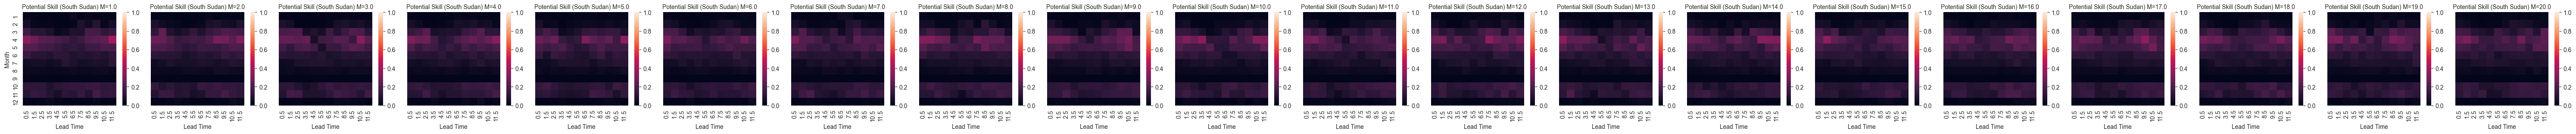

In [73]:
def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index=args[1], columns=args[0], values=args[2])
    sns.heatmap(d, **kwargs, vmin=0, vmax=1, cmap='rocket')

fg = sns.FacetGrid(stat_clean, col='M')
fg.map_dataframe(draw_heatmap, 'lead time', 'month', 'potential skill', square = True)
# get figure background color
facecolor = plt.gcf().get_facecolor()
for ax in fg.axes.flat:
    # set aspect of all axis
    ax.set_aspect('equal')
    ax.invert_yaxis()
fg.set_titles('Potential Skill (South Sudan) M={col_name}')
fg.set_ylabels("Month")
fg.set_xlabels("Lead Time")
plt.show()
fg.savefig('figures/CanESM5_potential_skill.png')

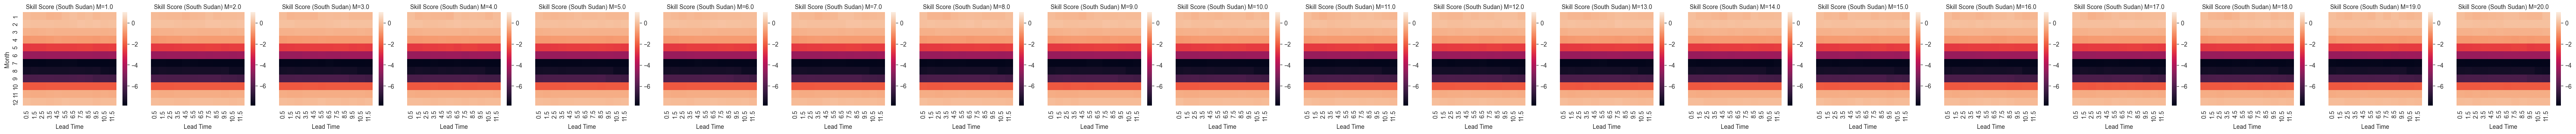

In [74]:
def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index=args[1], columns=args[0], values=args[2])
    sns.heatmap(d, **kwargs, vmax=1, cmap='rocket')

fg = sns.FacetGrid(stat_clean, col='M')
fg.map_dataframe(draw_heatmap, 'lead time', 'month', 'skill score', square=True)
# get figure background color
facecolor = plt.gcf().get_facecolor()
for ax in fg.axes.flat:
    # set aspect of all axis
    ax.set_aspect('equal')
    ax.invert_yaxis()
fg.set_titles('Skill Score (South Sudan) M={col_name}')
fg.set_ylabels("Month")
fg.set_xlabels("Lead Time")
plt.show()
fg.savefig('figures/CanESM5_skill_score.png')

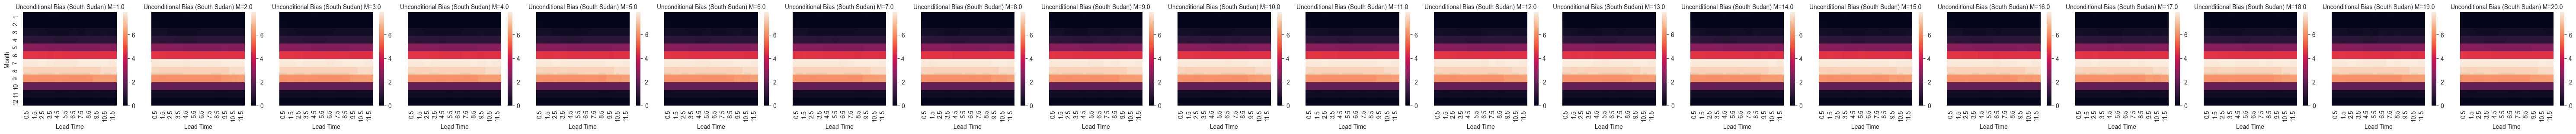

In [77]:
def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index=args[1], columns=args[0], values=args[2])
    sns.heatmap(d, **kwargs, vmin=0, cmap='rocket')

fg = sns.FacetGrid(stat_clean, col='M')
fg.map_dataframe(draw_heatmap, 'lead time', 'month', 'unconditional bias', square=True)
# get figure background color
facecolor = plt.gcf().get_facecolor()
for ax in fg.axes.flat:
    # set aspect of all axis
    ax.set_aspect('equal')
    ax.invert_yaxis()
fg.set_titles('Unconditional Bias (South Sudan) M={col_name}')
fg.set_ylabels("Month")
fg.set_xlabels("Lead Time")
plt.show()
fg.savefig('figures/CanESM5_unconditional_bias.png')

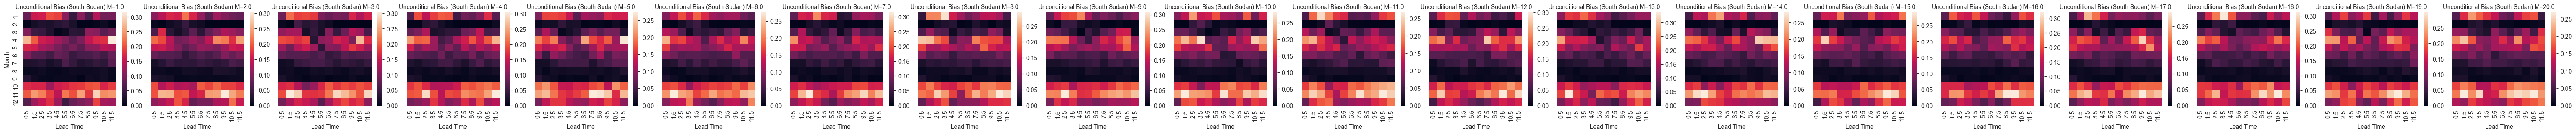

In [78]:
def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index=args[1], columns=args[0], values=args[2])
    sns.heatmap(d, **kwargs, vmin=0, cmap='rocket')

fg = sns.FacetGrid(stat_clean, col='M')
fg.map_dataframe(draw_heatmap, 'lead time', 'month', 'conditional bias', square=True)
# get figure background color
facecolor = plt.gcf().get_facecolor()
for ax in fg.axes.flat:
    # set aspect of all axis
    ax.set_aspect('equal')
    ax.invert_yaxis()
fg.set_titles('Unconditional Bias (South Sudan) M={col_name}')
fg.set_ylabels("Month")
fg.set_xlabels("Lead Time")
plt.show()
fg.savefig('figures/CanESM5_conditional_bias.png')